###  Description: Predicting Ethereum Price with Python and Machine Learning using Tensorflow and Keras and LSTM

In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
data = pd.read_csv('ethereum_2015-08-07_2024-09-08.csv')

# Sort data by the 'Start' date
data = data.sort_values('Start')

# Select relevant features
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Convert the scaled features into a DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)

# Display the first few rows of the scaled data
print(scaled_data.head())






       Open      High       Low     Close    Volume
0  0.000485  0.000476  0.000062  0.000057  0.000002
1  0.000066  0.000082  0.000044  0.000060  0.000004
2  0.000055  0.000051  0.000046  0.000056  0.000003
3  0.000057  0.000133  0.000051  0.000128  0.000004
4  0.000131  0.000166  0.000098  0.000166  0.000014


### Create Sequences for LSTM

In [16]:
import numpy as np

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i+sequence_length]
        target = data[i+sequence_length, 3]  # Assuming 'Close' is the target
        sequences.append((sequence, target))
    return sequences

sequence_length = 60  # Example sequence length
sequences = create_sequences(scaled_features, sequence_length)

# Split into training and testing sets
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

# Prepare the data for the LSTM model
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])


### Build and Train the LSTM Model


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0011 - val_loss: 0.0070
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 6.7271e-04 - val_loss: 0.0032
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 7.0617e-04 - val_loss: 0.0035
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 6.2068e-04 - val_loss: 0.0028
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 6.0347e-04 - val_loss: 0.0030
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 5.2523e-04 - val_loss: 0.0084
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 3.8810e-04 - val_loss: 0.0024
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 7.2990e-04 - val_loss: 0.0017
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 6.4467e-04 - val_loss: 0.0019
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 3.8948e-04 - val_loss: 0.0056
Epoch 12/20
66/66 ━━━━━━━━

In [29]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Loss: {loss * 100}%')





21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - loss: 2.3420e-04
Test Loss: 0.0004605294961947948
Test Loss: 0.04605294961947948%


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


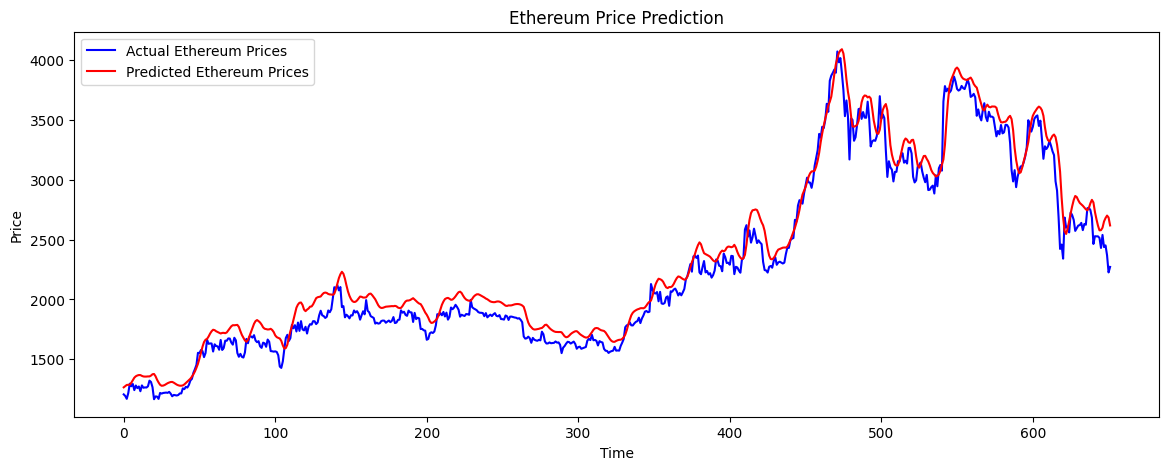

In [19]:
# Make predictions
predictions = model.predict(X_test)


# Reshape the predictions to match the scaler's expected input shape
predictions = predictions.reshape(-1, 1)

# Prepare a dummy array with the same shape as the scaled data (Open, High, Low, Close, Volume)
dummy_array = np.zeros((predictions.shape[0], scaled_features.shape[1]))

# Replace the 'Close' column in the dummy array with the predictions
dummy_array[:, 3] = predictions[:, 0]

# Perform inverse transformation
inverse_transformed_predictions = scaler.inverse_transform(dummy_array)

# Extract the predicted Close prices
predicted_prices = inverse_transformed_predictions[:, 3]

# Invert scaling for actual Close prices
actual_prices = y_test.reshape(-1, 1)
dummy_array = np.zeros((actual_prices.shape[0], scaled_features.shape[1]))
dummy_array[:, 3] = actual_prices[:, 0]
inverse_transformed_actual = scaler.inverse_transform(dummy_array)
actual_prices = inverse_transformed_actual[:, 3]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Ethereum Prices')
plt.plot(predicted_prices, color='red', label='Predicted Ethereum Prices')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### Save the Model

In [20]:
model.save('ethereum_price_prediction_lstm.keras')


## Load model

In [21]:
from tensorflow.keras.models import load_model

model = load_model('ethereum_price_prediction_lstm.keras')


### Early Stopping: To stop training when the model stops improving.
### Learning Rate Scheduler: To adjust the learning rate during training.

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    # Create a new optimizer instance
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model with the new optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model



### Train the model with early stopping:

In [23]:
# Create the model
model = create_model()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


c:\Users\Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.7454e-04 - val_loss: 0.0061
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.1454e-04 - val_loss: 0.0056
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 9.7619e-04 - val_loss: 0.0053
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 9.5933e-04 - val_loss: 0.0067
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.8726e-04 - val_loss: 0.0025
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 5.1946e-04 - val_loss: 0.0023
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.9864e-04 - val_loss: 0.0022
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.6079e-04 - val_loss: 0.0039
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 5.8625e-04 - val_loss: 0.0074
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 5.0096e-04 - val_loss: 0.0024
Epoch 12/100

### Hyperparameter Tuning

In [24]:
import kerastuner as kt

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=hp_units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    # Choose an optimal learning rate between 0.01 and 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error')
    
    return model

tuner = kt.Hyperband(model_builder,
                    objective='val_loss',
                    max_epochs=20,
                    factor=3,
                    directory='my_dir',
                    project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)


Trial 30 Complete [00h 02m 03s]
val_loss: 0.0026905129197984934

Best val_loss So Far: 0.0009584679501131177
Total elapsed time: 01h 25m 51s
Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 856ms/step - loss: 0.0032 - val_loss: 0.0124
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 877ms/step - loss: 5.9266e-04 - val_loss: 0.0049
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 912ms/step - loss: 5.8053e-04 - val_loss: 0.0135
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 883ms/step - loss: 4.7465e-04 - val_loss: 0.0023
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 3.2533e-04 - val_loss: 0.0014
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 3.0198e-04 - val_loss: 0.0013
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - loss: 3.7649e-04 - val_loss: 0.0033
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 3.5762e-04 - val_loss: 0.0117
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 9.7131e-04 - val_loss: 0.0024
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 881ms/step - los

# Model Architecture Visualization

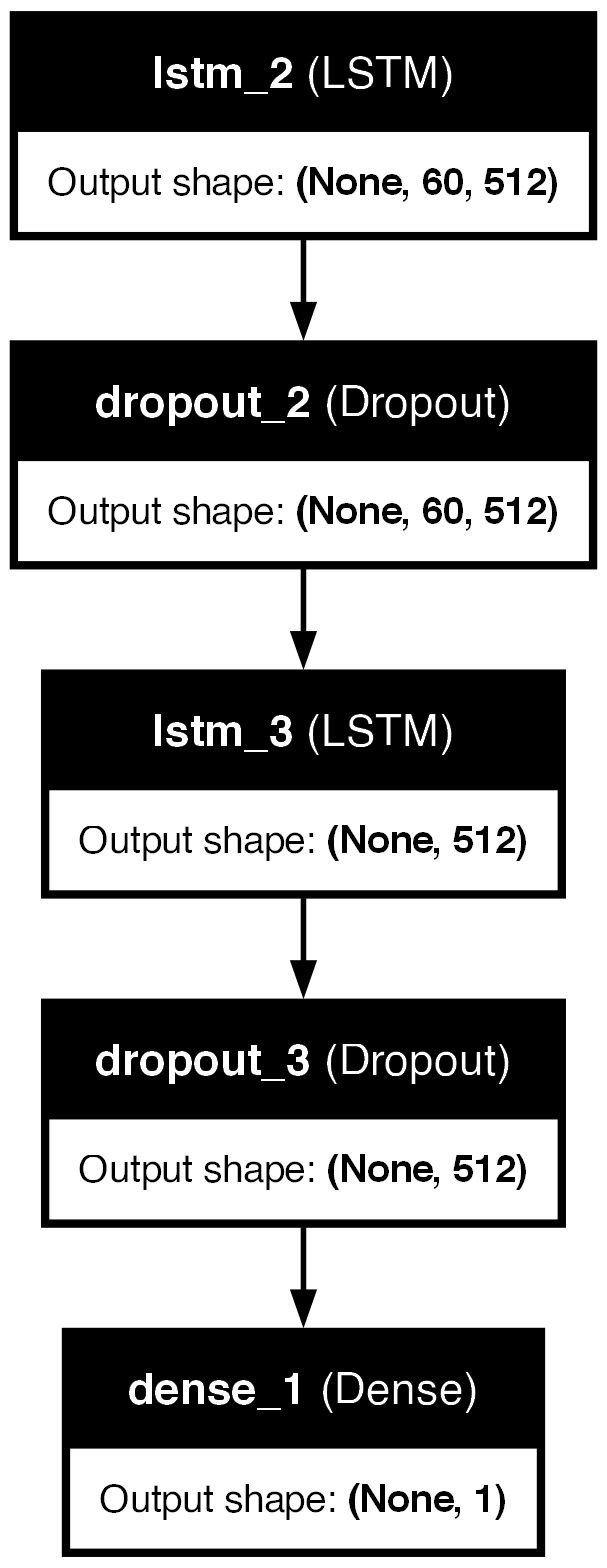

In [25]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


# Training History Visualization

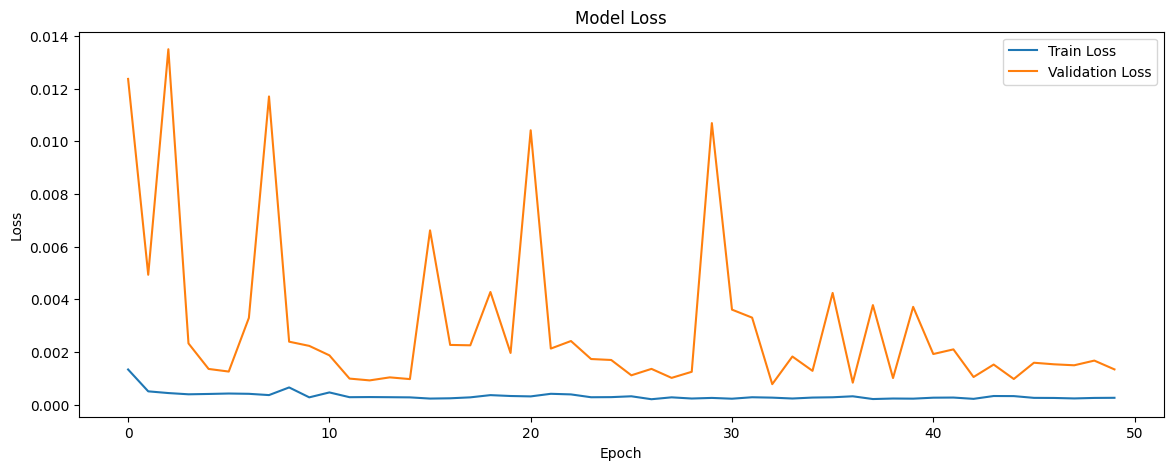

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Prediction Visualization

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step


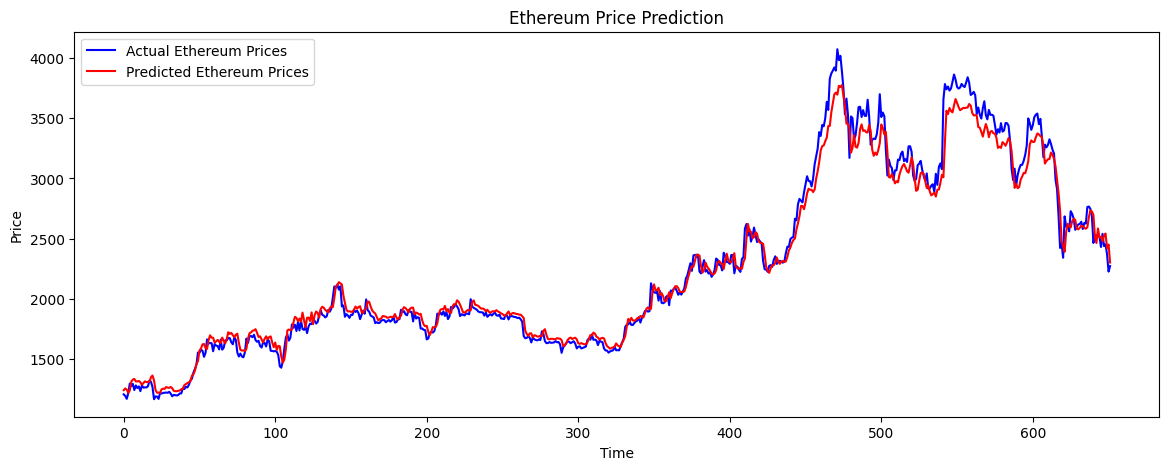

In [27]:
# Make predictions
predictions = model.predict(X_test)

# Reshape the predictions to match the scaler's expected input shape
predictions = predictions.reshape(-1, 1)

# Prepare a dummy array with the same shape as the scaled data (Open, High, Low, Close, Volume)
dummy_array = np.zeros((predictions.shape[0], scaled_features.shape[1]))

# Replace the 'Close' column in the dummy array with the predictions
dummy_array[:, 3] = predictions[:, 0]

# Perform inverse transformation
inverse_transformed_predictions = scaler.inverse_transform(dummy_array)

# Extract the predicted Close prices
predicted_prices = inverse_transformed_predictions[:, 3]

# Invert scaling for actual Close prices
actual_prices = y_test.reshape(-1, 1)
dummy_array = np.zeros((actual_prices.shape[0], scaled_features.shape[1]))
dummy_array[:, 3] = actual_prices[:, 0]
inverse_transformed_actual = scaler.inverse_transform(dummy_array)
actual_prices = inverse_transformed_actual[:, 3]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Actual Ethereum Prices')
plt.plot(predicted_prices, color='red', label='Predicted Ethereum Prices')
plt.title('Ethereum Price Prediction After Hyperparameter Tuning')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [35]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

# Assuming X_test and y_test are already defined and you have a trained model

# Make predictions on the test set
y_pred = model.predict(X_test)

# If you used a MinMaxScaler or any other scaler on your y values, you'll need to inverse transform
# Assuming you used a MinMaxScaler called scaler_y to scale your y values:
# y_pred = scaler_y.inverse_transform(y_pred)
# y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Flatten the predictions and actual values if they have more than 1 dimension
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
#print(f"Mean Squared Error: {mse}")
print(f"Mean Squared Error Percentage: {mse * 100:.2f}%")


# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
rmse_percentage = (rmse / max(y_test)) * 100
#print(f"Root Mean Squared Error: {rmse}")
print(f"Root Mean Squared Error (RMSE): {rmse_percentage:.2f}%")

# Calculate Mean Absolute Error (MAE)
mae = sum(abs(y_test - y_pred)) / len(y_test)
mae_percentage = (mae / max(y_test)) * 100
#print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Error (MAE): {mae_percentage:.2f}%")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
# print(f"R-squared: {r2}")
print(f"R-squared Percentage: {r2 * 100:.2f}%")

# If you want an accuracy score (though typically not used in regression)
# Define an accuracy metric, e.g., percentage of predictions within a certain threshold of actual value
accuracy = np.mean(np.abs(y_test - y_pred) <= 0.1 * y_test) * 100
print(f"Accuracy: {accuracy}%")


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step
Mean Squared Error Percentage: 0.05%
Root Mean Squared Error (RMSE): 2.54%
Mean Absolute Error (MAE): 1.80%
R-squared Percentage: 98.09%
Accuracy: 98.31288343558282%
